In [1]:
## ORIGINAL LOADING CODE, NOt import anymore I think - Gabby

import os
import json
from collections import defaultdict

# Path to the directory you want to search
directory_path = './'

# This will hold the count of unique combinations
combinations = defaultdict(int)
combination_set = set()
# Loop through each folder, subfolder, and file
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if the file is a JSON file
        if file.endswith('.json'):
            json_path = os.path.join(root, file)
            # Open and read the JSON file
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)
                # Extract the lesion and asymmetry values
                lesion_class = data.get("Lesion Class")
                asymmetry_label = data.get("Asymmetry Label")
                if lesion_class and asymmetry_label:
                    # Increment the count for this combination
                    combination_set.add((lesion_class, asymmetry_label))
                    combinations[(lesion_class, asymmetry_label)] += 1


# Now combinations dictionary has all unique combinations and their counts
total_combinations = len(combinations)
print(f'Total unique combinations of lesion and asymmetry: {total_combinations}')
print(combination_set)
# If you want to see the combinations,


Total unique combinations of lesion and asymmetry: 8
{('Atypical Nevus', 'Fully Symmetric'), ('Melanoma', 'Fully Symmetric'), ('Common Nevus', 'Symmetric in 1 axes'), ('Melanoma', 'Fully Asymmetric'), ('Common Nevus', 'Fully Asymmetric'), ('Atypical Nevus', 'Fully Asymmetric'), ('Atypical Nevus', 'Symmetric in 1 axes'), ('Common Nevus', 'Fully Symmetric')}


### Skin Lesion Segmentation Project
Team 7 Members (Undergraduate): Samhith Bhrugubanda, Gabby Kang, William Li, Sampath Rampuri

#### Section 1: Pre processing and Loading data

In [3]:
# Import relavant packages
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

In [6]:
# Load data
images = list()         # List of color images
masks = list()          # List of ground truth mask segmentations of the skin lesions
labels = list()         # List of classifications, each entry is a 2x1 vector of [lesion_class, assymmetry]
# Loop through each folder, subfolder, and file
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if the file is a JSON file
        if file.endswith('.json'):
            json_path = os.path.join(root, file)
            # Open and read the JSON file
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)
                # Extract the lesion and asymmetry values
                lesion_class = data.get("Lesion Class")
                asymmetry_label = data.get("Asymmetry Label")
                labels.append([lesion_class, asymmetry_label])
        # Check if the file is a JSON file
        elif file.endswith('.bmp'):
            im_path = os.path.join(root, file)
            if (file.__contains__("lesion")):
                masks.append(cv2.imread(im_path))
            else:
                images.append(cv2.imread(im_path))

#### Section 2: Segmentation
The following section contains helper functions for various morphological operators that are used to perform the segmentation. A sample process showing each morphological operation is shown separately, and all segmented images are stored in the list, mask_hat.

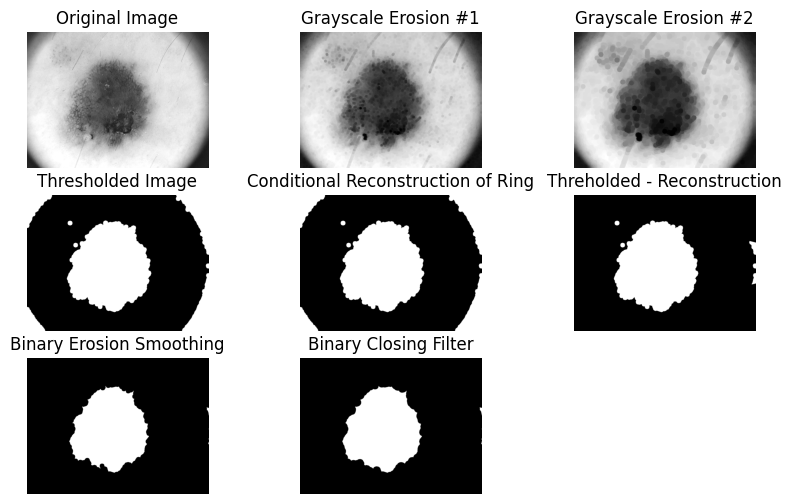

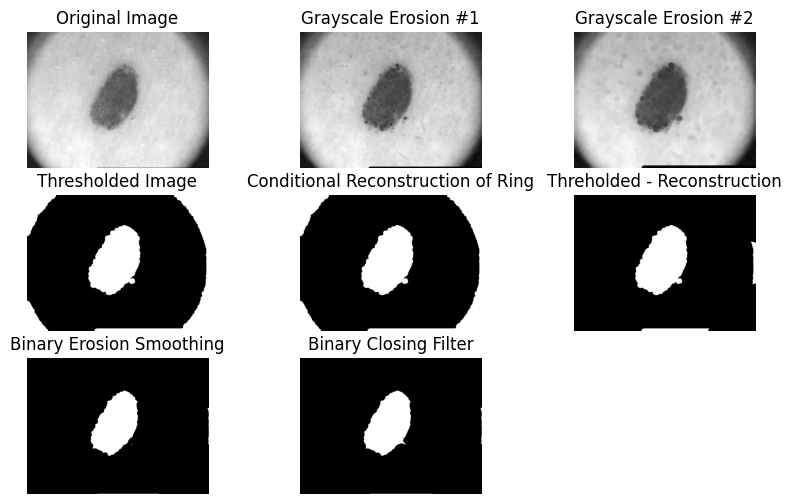

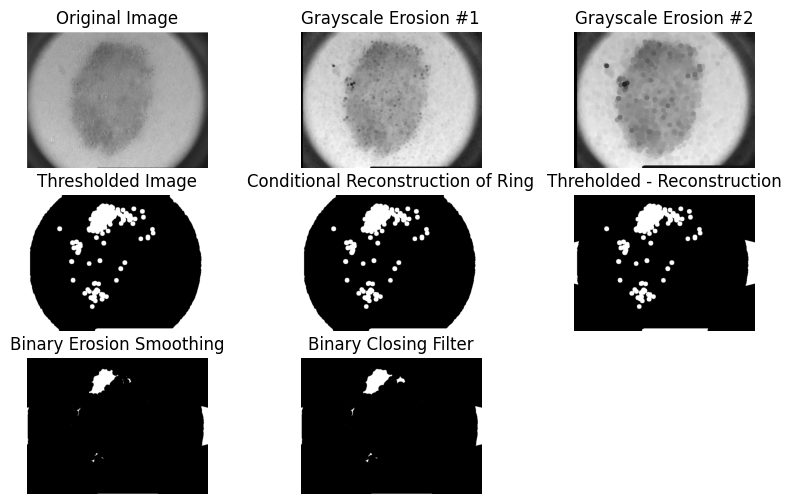

In [126]:
def generate_discrete_disk(radius):
    diameter = 2 * radius + 1 
    center = radius 

    # Generate a grid of coordinates
    x, y = np.meshgrid(np.arange(diameter), np.arange(diameter))

    # Calculate the distance from each point to the center
    distances = np.sqrt((x - center)**2 + (y - center)**2)

    # Create a mask for the disk
    disk_mask = (distances <= radius).astype(np.uint8)

    return disk_mask
def conditional_reconstruction(im, marker, b, num_iter = 10):
    for i in range(num_iter):
        temp = cv2.dilate(marker, b)
        marker = cv2.bitwise_and(im.astype(np.uint8), temp.astype(np.uint8))
    return marker
def plot_and_title(im, subplot_id, title):
    plt.subplot(subplot_id)
    plt.imshow(im, cmap = "gray")
    plt.title(title)
    plt.axis('off')  
def mask_segmentation(im, disp = False):
    # Initialize structural elements
    disk = generate_discrete_disk(5)
    big_disk = generate_discrete_disk(10)

    mask_steps = list()                             # List of intermediary steps, used for display purposes only
    mask = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)     # Initialize mask.
    mask_steps.append(mask)

    # Step 1: Use repeated grayscale erosion to smooth out color variation
    mask = cv2.erode(mask, disk)
    mask_steps.append(mask)
    mask = cv2.erode(mask, disk)
    mask_steps.append(mask)

    # Step 2: Perform an initial thresholding operation in order to generate a binary approximation
    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
    mask_steps.append(mask)

    # Step 3: Perform conditional reconstruction using the edge as a marker to get rid of ring edge artifact
    edge_marker = np.zeros(mask.shape)
    edge_marker[0, 0] = 1
    edge_marker[-1, 0] = 1
    edge_marker[0, -1] = 1
    edge_marker[-1,-1] = 1
    recon = conditional_reconstruction(mask, edge_marker, big_disk, num_iter = 20)
    mask_steps.append(mask) 

    # Step 4: Remove edge artifact by subtracting the conditional reconstruction from the original mask
    mask = mask == cv2.bitwise_not(recon.astype(np.uint8))
    mask_steps.append(mask)

    # Step 5: Smooth the binary mask with an erosion. This has the added benefit of reducing the size of
    #         segmented regions, making small artificial regions easy to filter out in the later steps
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_ERODE, big_disk)
    mask_steps.append(mask)
    
    # Step 6: Smooth the binary mask with a dilation to restore some of the original size
    # mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_DILATE, disk)
    # mask_steps.append(mask)

    # Step 7: Filter out small foreground shapes with a binary closing.
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, generate_discrete_disk(15))
    mask_steps.append(mask)
    # Plot each intermediary step
    if (disp == True):
        plt.figure(figsize=(10, 6)) 
        plot_and_title(mask_steps[0], 331, "Original Image")
        plot_and_title(mask_steps[1], 332, "Grayscale Erosion #1")
        plot_and_title(mask_steps[2], 333, "Grayscale Erosion #2")
        plot_and_title(mask_steps[3], 334, "Thresholded Image")
        plot_and_title(mask_steps[4], 335, "Conditional Reconstruction of Ring")
        plot_and_title(mask_steps[5], 336, "Threholded - Reconstruction")
        plot_and_title(mask_steps[6], 337, "Binary Erosion Smoothing")
        plot_and_title(mask_steps[7], 338, "Binary Closing Filter")

    return mask

mask = mask_segmentation(images[121], disp = True)
mask = mask_segmentation(images[100], disp = True)
mask = mask_segmentation(images[4], disp = True)


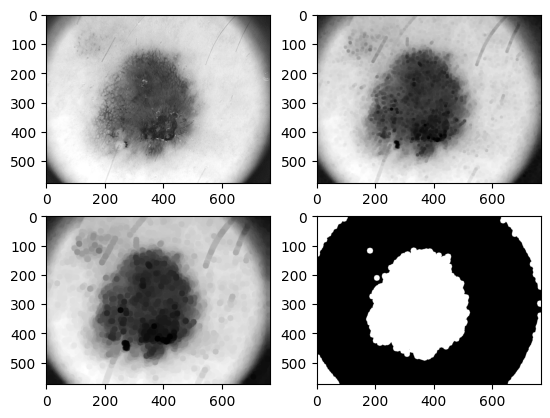

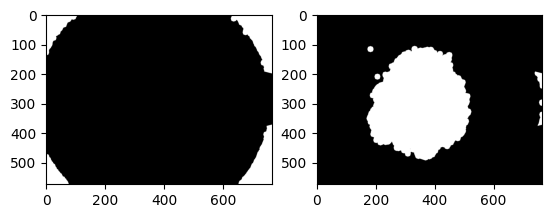

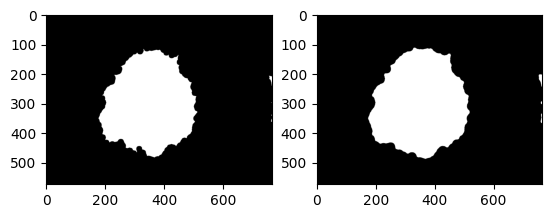

In [115]:
im = cv2.cvtColor(images[121], cv2.COLOR_BGR2GRAY)
plt.figure()
plt.subplot(221)
plt.imshow(im, cmap = "gray")
plt.subplot(222)
im = cv2.erode(im, disk)
plt.imshow(im, cmap = "gray")

plt.subplot(223)
im = cv2.erode(im, disk)
plt.imshow(im, cmap = "gray")

plt.subplot(224)
_, im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
plt.imshow(im, cmap = "gray")

# Perform conditional reconstruction using the edge as a marker to get rid of ring edge artifact
edge_marker = np.zeros(im.shape)
edge_marker[0, 0] = 1
edge_marker[-1, 0] = 1
edge_marker[0, -1] = 1
edge_marker[-1,-1] = 1
recon = conditional_reconstruction(im, edge_marker, big_disk, num_iter = 20)
plt.figure()
plt.subplot(121)
plt.imshow(recon, cmap = "gray")
plt.subplot(122)
im = im == cv2.bitwise_not(recon.astype(np.uint8))
plt.imshow(im, cmap = "gray")

# Perform some smoothing operation by with a binary closing
im = cv2.morphologyEx(im.astype(np.uint8), cv2.MORPH_ERODE, generate_discrete_disk(10))


plt.figure()
plt.subplot(121)
plt.imshow(im, cmap = "gray")
plt.subplot(122)
im = cv2.morphologyEx(im.astype(np.uint8), cv2.MORPH_DILATE, generate_discrete_disk(5))
im = cv2.morphologyEx(im.astype(np.uint8), cv2.MORPH_CLOSE, generate_discrete_disk(15))
plt.imshow(im, cmap = "gray")